In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
import scipy

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
import pandas as pd

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image, Markdown, display
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import SplineTransformer
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [2]:
df = pd.read_csv("../DATA/aus_production.csv")
df.ds = pd.to_datetime(df.ds)
gas = df[["ds"]]
gas["unique_id"] = "gas"
gas["y"] = df["Gas"]
gas.head()

,ds,unique_id,y
0,1956-01-01,gas,5
1,1956-04-01,gas,6
2,1956-07-01,gas,7
3,1956-10-01,gas,6
4,1957-01-01,gas,5


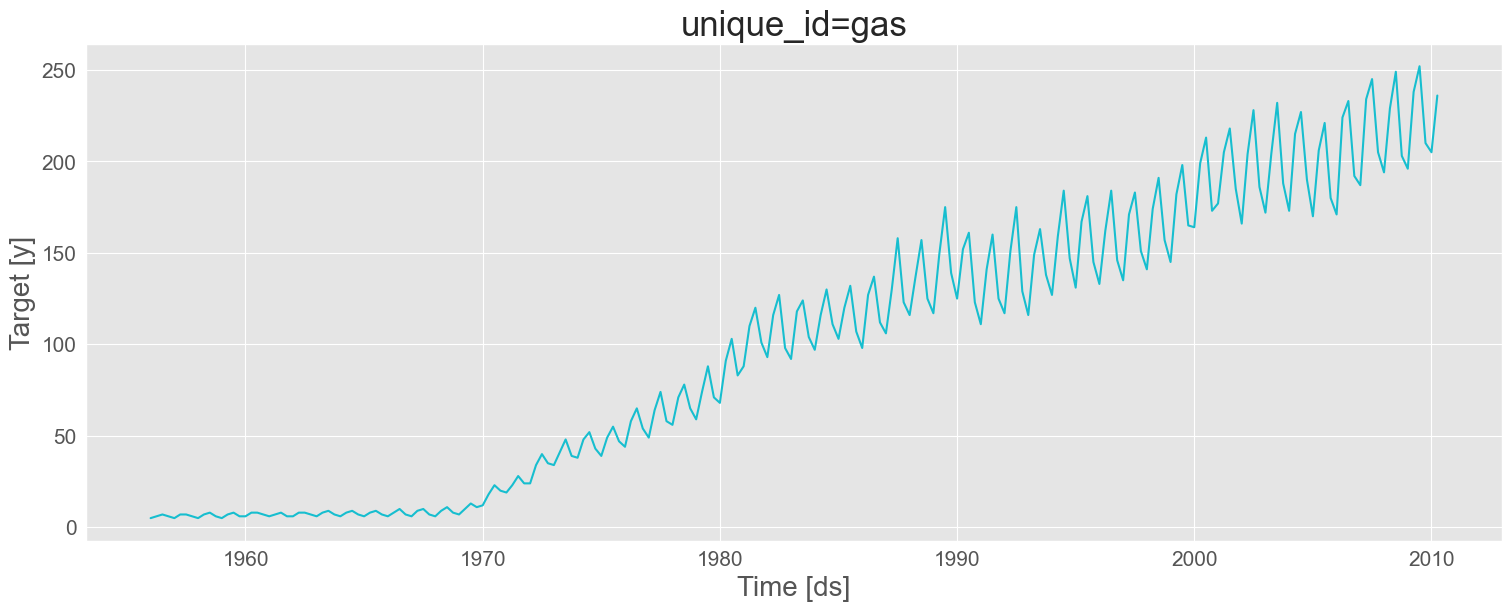

In [3]:
plot_series(gas)

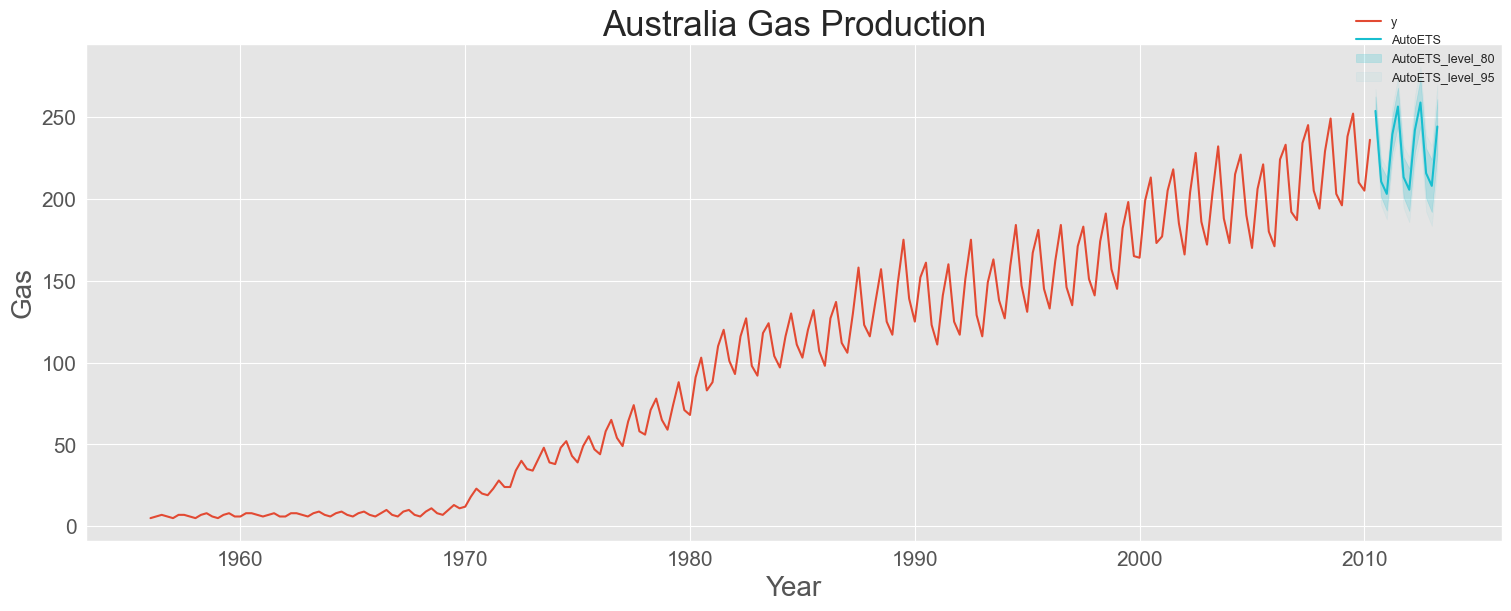

In [4]:
sf = StatsForecast(
    models=[AutoETS(model="AAA", season_length=4, damped=True)], freq="Q"
)
fc = sf.forecast(df=gas, h=12, level=[80, 95], fitted=True)
plot_series(
    gas,
    fc,
    level=[80, 95],
    xlabel="Year",
    ylabel="Gas",
    title="Australia Gas Production",
    rm_legend=False,
)

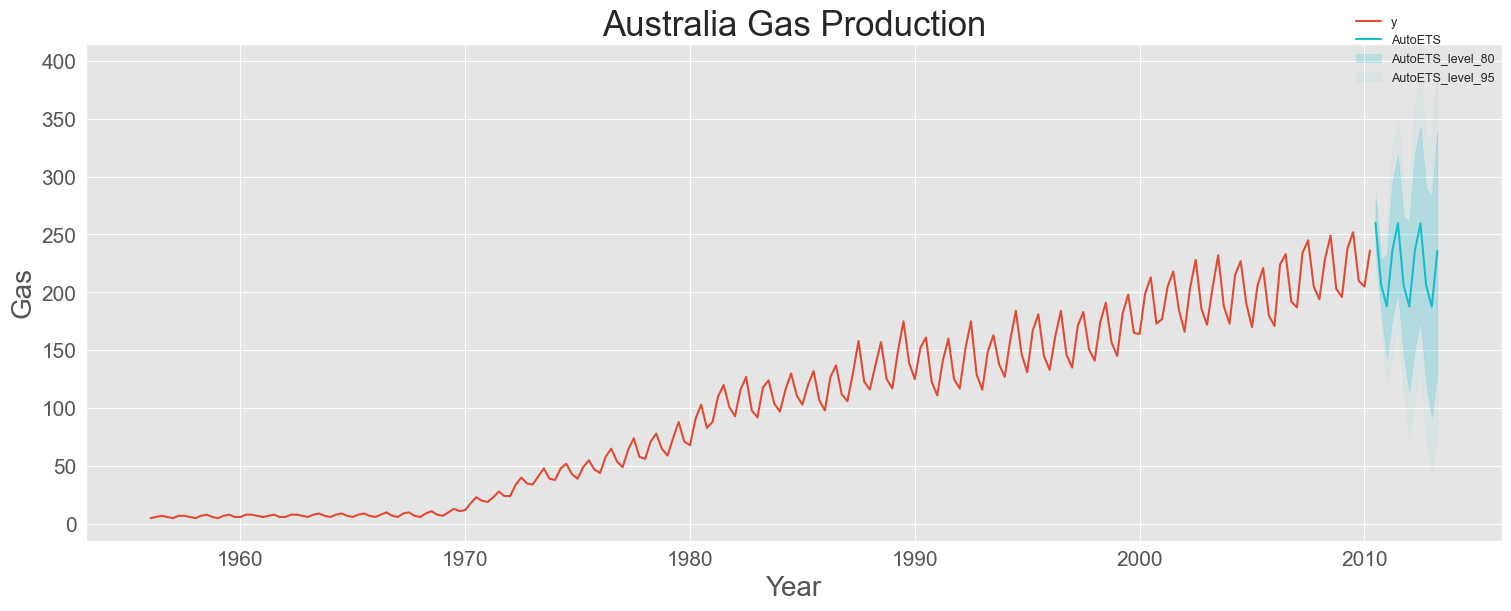

In [5]:
sfm = StatsForecast(
    models=[AutoETS(model="MAM", season_length=4, damped=True)], freq="Q"
)
fcm = sfm.forecast(df=gas, h=12, level=[80, 95], fitted=True)
plot_series(
    gas,
    fcm,
    level=[80, 95],
    xlabel="Year",
    ylabel="Gas",
    title="Australia Gas Production",
    rm_legend=False,
)

In [6]:
insample_a = sf.forecast_fitted_values()
insample_m = sfm.forecast_fitted_values()
resid_a = insample_a["y"] - insample_a["AutoETS"]
resid_m = insample_m["y"] - insample_m["AutoETS"]

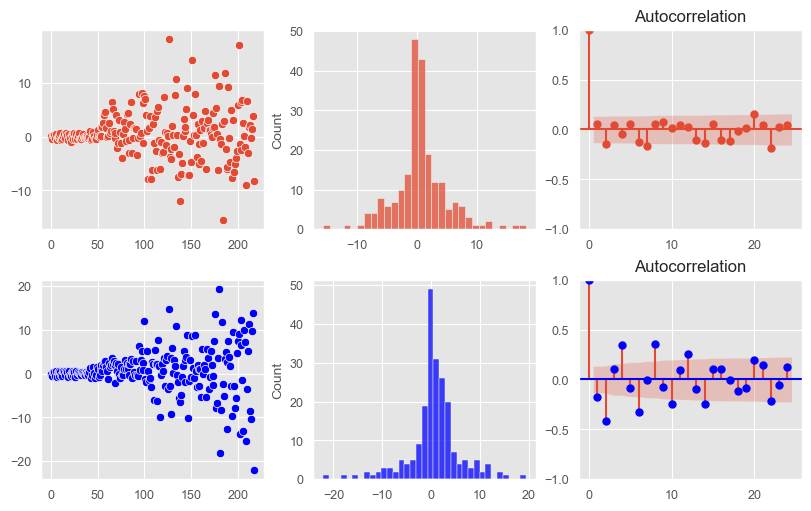

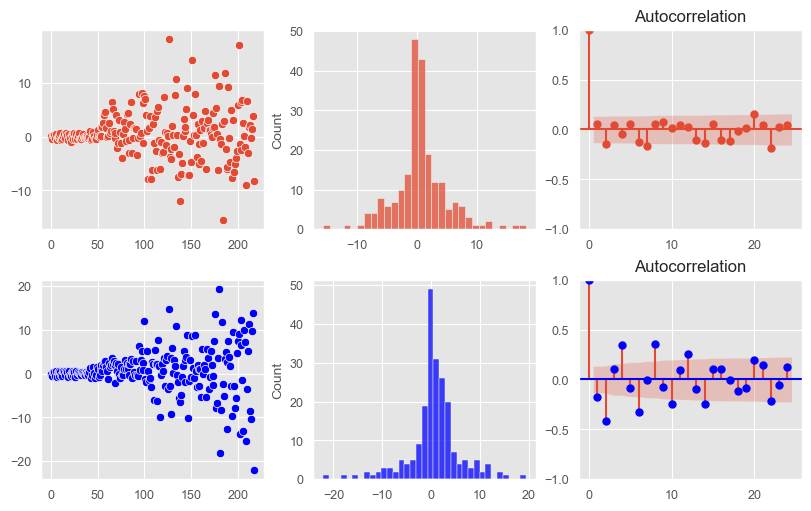

In [7]:
fix, axes = plt.subplots(2, 3)

sns.scatterplot(resid_a, ax=axes[0, 0])
sns.histplot(resid_a, ax=axes[0, 1])
plot_acf(resid_a, ax=axes[0, 2])

sns.scatterplot(resid_m, ax=axes[1, 0], color="blue")
sns.histplot(resid_m, ax=axes[1, 1], color="blue")
plot_acf(resid_m, ax=axes[1, 2], color="blue")

In [8]:
autoets = AutoETS(season_length=4, model="AAA")
autoets = autoets.fit(y=gas.y.values)

autoets_m = AutoETS(season_length=4, model="MAM")
autoets_m = autoets_m.fit(y=gas.y.values)

params = np.round(autoets.model_["fit"][0], 4)
print("Optimal parameters:")
print("alpha:", params[0])
print("beta:", params[1])
print("gamma:", params[2])
print("Initial level:", params[3])
print("Initial seasonal components:", params[4 : len(params)])

Optimal parameters:
alpha: 0.5776
beta: 0.0162
gamma: 0.3527
Initial level: 5.5142
Initial seasonal components: [ 0.1147 -0.3905  0.9409  0.4512]


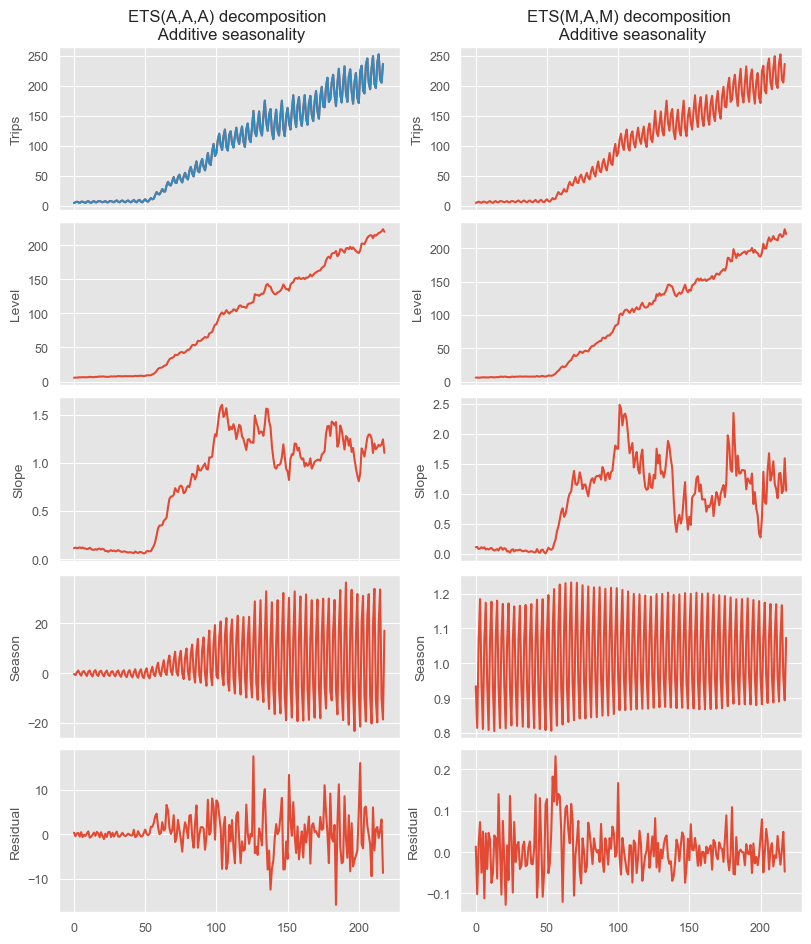

In [9]:
add_fitted_model = autoets.model_
mult_fitted_model = autoets_m.model_

fig, axes = plt.subplots(5, 2, figsize=(8, 8 * 14 / 12), sharex=True)
axes[0, 0].plot(gas.y.values)
axes[0, 0].set_title("ETS(A,A,A) decomposition \n Additive seasonality")
axes[0, 0].set_ylabel("Trips")

axes[0, 1].plot(gas.y.values)
axes[0, 1].set_title("ETS(M,A,M) decomposition \n Additive seasonality")
axes[0, 1].set_ylabel("Trips")

axes[1, 0].plot(add_fitted_model["states"][:, 0])
axes[1, 0].set_ylabel("Level")

axes[2, 0].plot(add_fitted_model["states"][:, 1])
axes[2, 0].set_ylabel("Slope")

axes[3, 0].plot(add_fitted_model["states"][:, 2])
axes[3, 0].set_ylabel("Season")

axes[4, 0].plot(add_fitted_model["residuals"])
axes[4, 0].set_ylabel("Residual")

axes[0, 0].plot(gas.y.values)
axes[0, 0].set_title("ETS(A,A,A) decomposition \n Additive seasonality")
axes[0, 0].set_ylabel("Trips")

axes[1, 1].plot(mult_fitted_model["states"][:, 0])
axes[1, 1].set_ylabel("Level")

axes[2, 1].plot(mult_fitted_model["states"][:, 1])
axes[2, 1].set_ylabel("Slope")

axes[3, 1].plot(mult_fitted_model["states"][:, 2])
axes[3, 1].set_ylabel("Season")

axes[4, 1].plot(mult_fitted_model["residuals"])
axes[4, 1].set_ylabel("Residual")

for ax in axes.flat:
    ax.grid(True)
plt.show()

Let's see what is the best model with crossvalidation

In [81]:
sfm = StatsForecast(models=[AutoETS(model="MAM", season_length=4)], freq="Q")
sfa = StatsForecast(models=[AutoETS(model="AAA", season_length=4)], freq="Q")
sfmd = StatsForecast(
    models=[AutoETS(model="MAM", season_length=4, damped=True)], freq="Q"
)
sfad = StatsForecast(
    models=[AutoETS(model="AAA", season_length=4, damped=True)], freq="Q"
)
sf_auto = StatsForecast(models=[AutoETS(season_length=4)], freq="Q")


levels = np.arange(0, 100, 1 / 10)
n_windows = 30
step_size = 4
h = 8

sfm_cross_val = sfm.cross_validation(
    df=gas, h=h, step_size=step_size, n_windows=n_windows, level=levels
)
sfa_cross_val = sfa.cross_validation(
    df=gas, h=h, step_size=step_size, n_windows=n_windows, level=levels
)
sfmd_cross_val = sfmd.cross_validation(
    df=gas, h=h, step_size=step_size, n_windows=n_windows, level=levels
)
sfad_cross_val = sfad.cross_validation(
    df=gas, h=h, step_size=step_size, n_windows=n_windows, level=levels
)
sf_auto_cross_val = sf_auto.cross_validation(
    df=gas, h=h, step_size=step_size, n_windows=n_windows, level=levels
)

In [82]:
sfm_mqloss = evaluate(
    df=sfm_cross_val,
    models=[sfm.models[0]],
    metrics=[mqloss],
    level=levels,
)

sfa_mqloss = evaluate(
    df=sfa_cross_val,
    models=[sfa.models[0]],
    metrics=[mqloss],
    level=levels,
)

sfad_mqloss = evaluate(
    df=sfad_cross_val,
    models=[sfad.models[0]],
    metrics=[mqloss],
    level=levels,
)

sfmd_mqloss = evaluate(
    df=sfmd_cross_val,
    models=[sfmd.models[0]],
    metrics=[mqloss],
    level=levels,
)

sf_auto_mqloss = evaluate(
    df=sf_auto_cross_val,
    models=[sf_auto.models[0]],
    metrics=[mqloss],
    level=levels,
)

In [87]:
print(
    f""" Cross validation RMSE : 
sfm : {root_mean_squared_error(sfm_cross_val.y, sfm_cross_val.AutoETS)}
sfa : {root_mean_squared_error(sfa_cross_val.y, sfa_cross_val.AutoETS)}
sfmd : {root_mean_squared_error(sfmd_cross_val.y, sfmd_cross_val.AutoETS)}
sfad : {root_mean_squared_error(sfad_cross_val.y, sfad_cross_val.AutoETS)}
sf_auto : {root_mean_squared_error(sf_auto_cross_val.y, sf_auto_cross_val.AutoETS)}
"""
)

print(
    f""" Cross validation CRPS : 
sfm : {sfm_mqloss.iloc[0, 2]}
sfa : {sfa_mqloss.iloc[0, 2]}
sfmd : {sfmd_mqloss.iloc[0, 2]}
sfad : {sfad_mqloss.iloc[0, 2]}
sf_auto : {sf_auto_mqloss.iloc[0, 2]}
"""
)

 Cross validation RMSE : 
sfm : 8.873306274414062
sfa : 8.620381355285645
sfmd : 9.643799781799316
sfad : 8.97790241241455
sf_auto : 8.873306274414062

 Cross validation CRPS : 
sfm : 3.9165774915845626
sfa : 2.454361290474526
sfmd : 4.128760621385431
sfad : 2.5499096694037315
sf_auto : 3.9165774915845626

